# 3. Data Preparation

In this phase we will prepare the dataset, modifying it according to the previous phase. In the end of this notebook we should have a dataset ready to be used in modelling.

## 3.1 Select Data

We begin by loading the complete raw data so that we have more flexibility in the preparation of the data.

The selection of the most relevant variables will be done in the next steps.

In [1]:
import pandas as pd

student = pd.read_csv("../../../databases/2022/STU_QQQ_SAS/student2022.csv")

## 3.2 Clean Data

From the previous phase, we decided to remove unnecessary variables according the following criteria:
- Variables with more than 70% missing values.
- Students from England, due to differences in their education system.

In [2]:
missing = student.isnull().mean().sort_values(ascending=False)
clean_students = student.drop(columns=missing[missing > 0.7].index)

clean_students = clean_students[(clean_students["CNT"] != "b'GBR'")]

clean_students.head(5)

,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT,VER_DAT
0,ALB,8.0,800282.0,800001.0,08MS,800,ALB03,80000,800.0,0.0,...,226.250,203.029,219.817,331.017,223.752,305.671,230.156,289.436,0.55561,03MAY23:10:11:25
1,ALB,8.0,800115.0,800002.0,08MS,800,ALB03,80000,800.0,0.0,...,298.644,321.405,320.452,284.836,364.565,304.044,347.626,352.269,0.76431,03MAY23:10:11:25
2,ALB,8.0,800242.0,800003.0,08MS,800,ALB01,80000,800.0,0.0,...,383.340,376.019,285.901,289.896,338.469,316.296,324.361,343.351,1.37877,03MAY23:10:11:25
3,ALB,8.0,800245.0,800005.0,08MS,800,ALB08,80000,800.0,0.0,...,264.532,303.422,327.793,165.575,246.156,238.322,275.860,227.466,1.49361,03MAY23:10:11:26
4,ALB,8.0,800285.0,800006.0,08MS,800,ALB03,80000,800.0,0.0,...,399.300,514.739,539.850,461.793,514.465,510.462,490.537,503.793,0.65249,03MAY23:10:11:26


## 3.3 Construct Data

In this step, we construct new variables based on the available data.

For each subject, there are 10 plausible values (PVs), which we averaged into a single score column per subject.

In [3]:
from columns_list import (
    math_subscales,
    math_columns,
    science_columns,
    reading_columns,
    get_math_results,
    get_science_results,
    get_reading_results,
)

def remove_columns(dataframe, column_list):
    new_df = dataframe.copy()
    new_df = new_df.drop(columns=column_list)

    return new_df

def get_student_results(dataframe, math_columns, science_columns, reading_columns):
    new_df = dataframe.copy()
    new_df = get_math_results(new_df, math_columns)
    new_df = get_science_results(new_df, science_columns)
    new_df = get_reading_results(new_df, reading_columns)

    return new_df

In [4]:
filtered_student = get_student_results(
    clean_students, math_columns, science_columns, reading_columns
)

We'll also remove mathematic subscales as they are already captured by the aggregated Math Result score.

In [5]:
filtered_student = remove_columns(filtered_student, math_subscales)

In [6]:
filtered_student.head(5)

,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,W_FSTURWT78,W_FSTURWT79,W_FSTURWT80,UNIT,WVARSTRR,SENWT,VER_DAT,Avg Math Result,Avg Science Result,Avg Reading Result
0,ALB,8.0,800282.0,800001.0,08MS,800,ALB03,80000,800.0,0.0,...,1.59631,1.58021,4.70887,1.0,50.0,0.55561,03MAY23:10:11:25,223.0351,301.2603,249.8026
1,ALB,8.0,800115.0,800002.0,08MS,800,ALB03,80000,800.0,0.0,...,2.12833,2.16631,6.40402,1.0,41.0,0.76431,03MAY23:10:11:25,308.4938,303.5314,288.8999
2,ALB,8.0,800242.0,800003.0,08MS,800,ALB01,80000,800.0,0.0,...,11.86015,11.79079,3.96558,1.0,19.0,1.37877,03MAY23:10:11:25,313.7353,323.6492,311.7785
3,ALB,8.0,800245.0,800005.0,08MS,800,ALB08,80000,800.0,0.0,...,13.51571,4.53800,4.41017,1.0,38.0,1.49361,03MAY23:10:11:26,298.7323,210.1502,300.7753
4,ALB,8.0,800285.0,800006.0,08MS,800,ALB03,80000,800.0,0.0,...,5.55627,5.78305,5.80990,1.0,56.0,0.65249,03MAY23:10:11:26,475.7512,466.7572,486.6689


## 3.4 Integrate Data

For this dataset, there was nothing relevant in this step.

## 3.5 Format Data

In the previous phase we concluded that Country variable should be grouped into fewer values to avoid high dimensionality.

To reduce the cardinality of the "CNT" (Country) variable while preserving meaningful educational information, countries were grouped into three categories based on their average PISA performance: Above Average, Average, and Below Average.

In [7]:
country_avg_scores = filtered_student.groupby("CNT")["Avg Math Result"].mean()
tolerance = 15
global_avg = country_avg_scores.mean()


def categorize_country(score):
    if score >= global_avg + tolerance:
        return "Above Average"
    elif score <= global_avg - tolerance:
        return "Below Average"
    else:
        return "Average"

country_performance_group = country_avg_scores.apply(categorize_country)

filtered_student["CNT_Group"] = filtered_student["CNT"].map(country_performance_group)
filtered_student["CNT_Group"] = filtered_student["CNT_Group"].astype("category")

print(filtered_student["CNT_Group"].value_counts())

CNT_Group
Above Average    292895
Below Average    233110
Average           87739
Name: count, dtype: int64


## Correlation chart

Using a more cleaner dataset, we can check again the correlations between the dataset features and the target variable (average math result).

In [8]:
vocational_students = filtered_student[filtered_student["ISCEDP"].isin([254, 354, 453])]
non_vocational_students = filtered_student[filtered_student["ISCEDP"].isin([244, 341, 343, 344])]

vocational_correlations = vocational_students.corr(numeric_only=True)[
    "Avg Math Result"
].sort_values(ascending=False)

vocational_correlations = vocational_correlations.drop("Avg Math Result")

non_vocational_correlations = non_vocational_students.corr(numeric_only=True)[
    "Avg Math Result"
].sort_values(ascending=False)

non_vocational_correlations = non_vocational_correlations.drop("Avg Math Result")

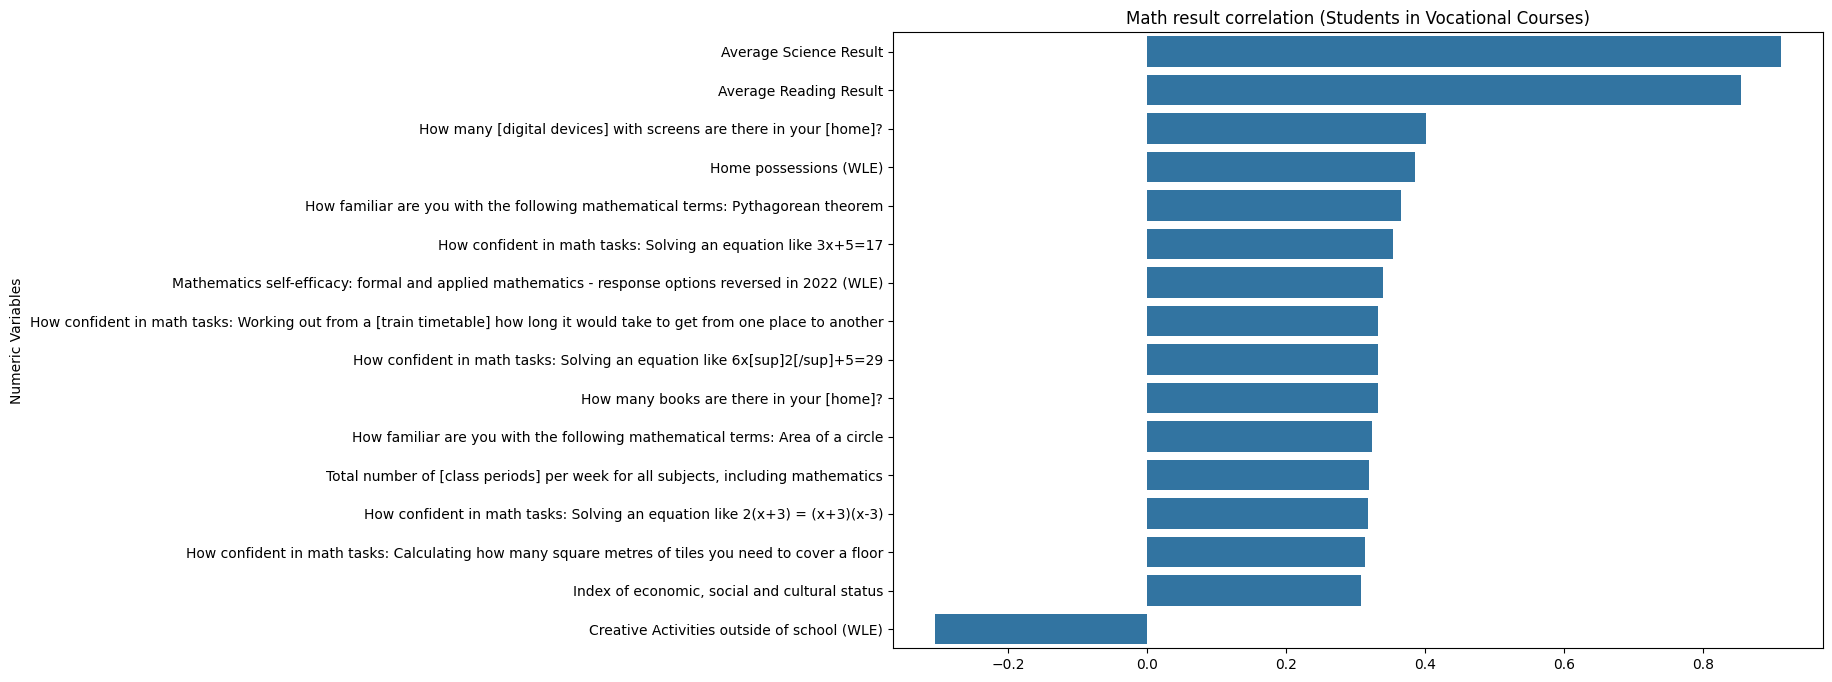

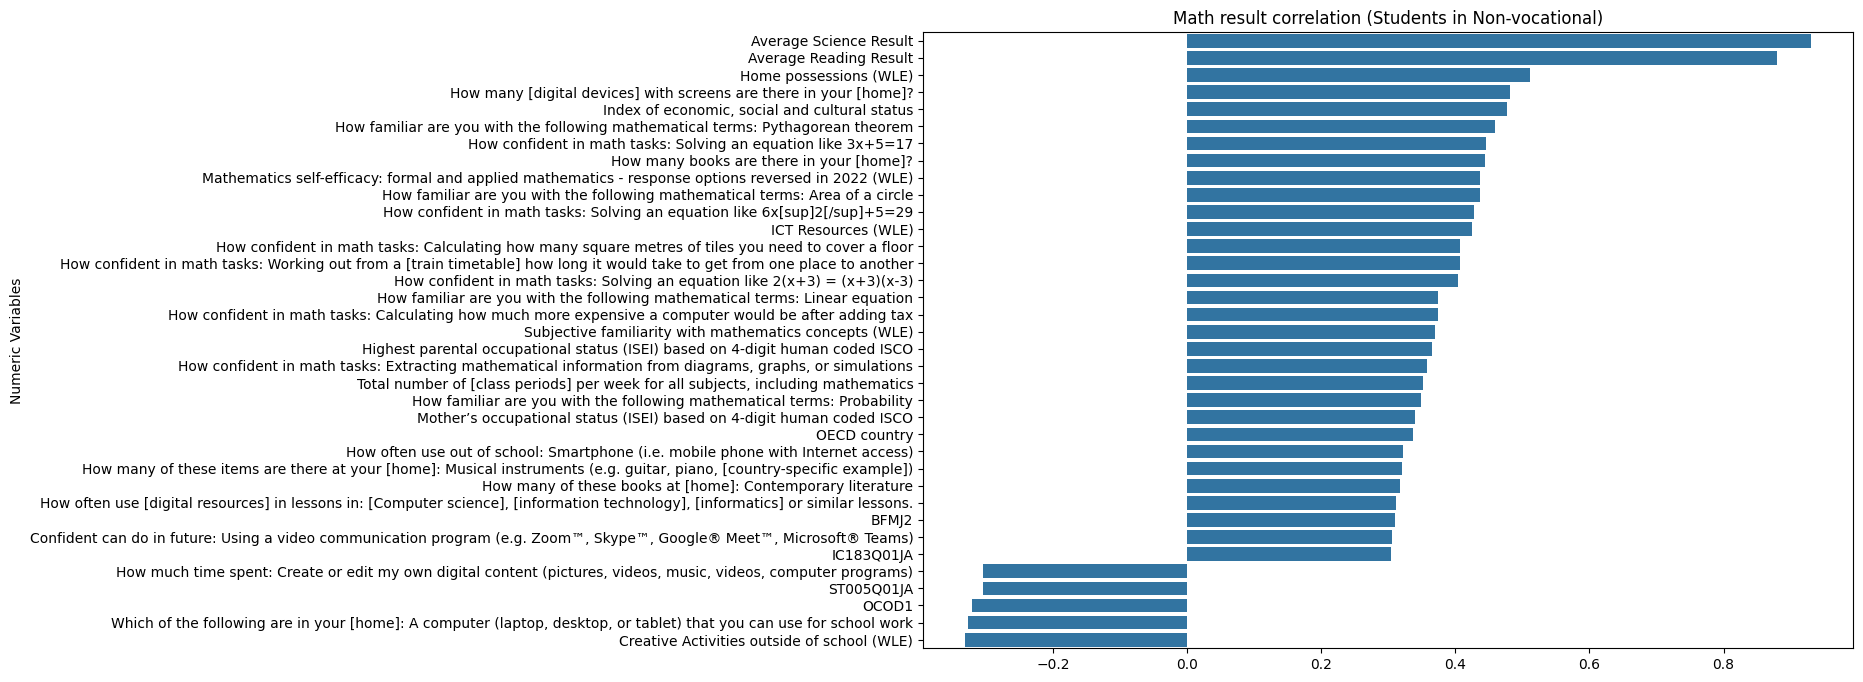

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from dictionary import column_mapping

vocational_correlations = vocational_correlations[vocational_correlations.abs() > 0.3]
non_vocational_correlations = non_vocational_correlations[
    non_vocational_correlations.abs() > 0.3
]
vocational_correlations.index = [
    column_mapping.get(col, col) for col in vocational_correlations.index
]
non_vocational_correlations.index = [
    column_mapping.get(col, col) for col in non_vocational_correlations.index
]

plt.figure(figsize=(12, 8))

sns.barplot(x=vocational_correlations.values, y=vocational_correlations.index)
plt.title("Math result correlation (Students in Vocational Courses)")
plt.ylabel("Numeric Variables")
plt.show()

plt.figure(figsize=(12, 8))

sns.barplot(x=non_vocational_correlations.values, y=non_vocational_correlations.index)
plt.title("Math result correlation (Students in Non-vocational)")
plt.ylabel("Numeric Variables")

plt.show()

<!-- Since the focus is on repeating students, we prioritized features that show a strong correlation with this group. -->

Following the correlation analysis, we opted to incorporate variables identified as significant from both the vocational and non-vocational student groups. This mixed feature selection strategy aims to leverage complementary insights from both subsets, enhancing the robustness of the final dataset.

## 3.1 Select Data (Cont.)

After completing the data analysis, we merged the selected numerical and categorical variables to work with a smaller dataset.

In [15]:
from collections import OrderedDict


reversed_column_mapping = {v: k for k, v in column_mapping.items()}
vocational_original_columns = [
    reversed_column_mapping.get(col, col) for col in vocational_correlations.index
]
non_vocational_original_columns = [
    reversed_column_mapping.get(col, col) for col in non_vocational_correlations.index
]

columns_to_include = list(
    OrderedDict.fromkeys(
        vocational_original_columns
        + non_vocational_original_columns
        + ["Avg Math Result", "CNT_Group"]
        + ["REPEAT"]
        + ["ISCEDP"]
    )
)

filtered_cols_dataset = filtered_student[columns_to_include].copy()
filtered_cols_dataset = filtered_cols_dataset[sorted(filtered_cols_dataset.columns)]
filtered_cols_dataset

,Avg Math Result,Avg Reading Result,Avg Science Result,BFMJ2,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,...,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST290Q07WA,ST290Q09WA,ST291Q01JA,ST355Q02JA
0,223.0351,249.8026,301.2603,16.50,73.91,Below Average,NaN,1.1112,NaN,73.91,...,NaN,NaN,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN
1,308.4938,288.8999,303.5314,NaN,24.16,Below Average,NaN,-3.0507,NaN,24.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,313.7353,311.7785,323.6492,NaN,NaN,Below Average,NaN,-0.1867,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
3,298.7323,300.7753,210.1502,14.82,NaN,Below Average,1.4468,-3.2198,0.4222,14.82,...,NaN,4.0,NaN,2.0,NaN,NaN,2.0,2.0,NaN,2.0
4,475.7512,486.6689,466.7572,30.11,17.00,Below Average,1.8557,-1.0548,1.1266,30.11,...,NaN,4.0,1.0,NaN,NaN,2.0,4.0,NaN,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613739,327.0151,312.5706,288.5284,28.95,17.00,Below Average,NaN,-2.7487,NaN,28.95,...,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,4.0,NaN
613740,286.4383,271.9545,282.6895,30.11,73.91,Below Average,NaN,-0.2024,NaN,73.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613741,411.8666,330.4373,380.6084,25.71,17.00,Below Average,0.6097,-2.0506,NaN,25.71,...,NaN,NaN,NaN,3.0,3.0,4.0,3.0,4.0,3.0,NaN
613742,338.1192,353.0499,372.8060,75.43,73.91,Below Average,NaN,-0.1290,NaN,75.43,...,NaN,NaN,3.0,3.0,NaN,3.0,3.0,NaN,4.0,NaN


We proceeded to make some adjustments to a few questionnaire responses that were effectively equivalent to missing data. In particular, one of the responses was "I don't know", which was encoded with the maximum value of 6 in a 1–5 scale. Since this value does not represent a valid position on the scale, we treated it as missing data to avoid introducing bias or distortion in the analysis.

In [17]:
import numpy as np

filtered_cols_dataset["ST256Q03JA"] = filtered_cols_dataset["ST256Q03JA"].replace(
    5, np.nan
)
filtered_cols_dataset["IC173Q04JA"] = filtered_cols_dataset["IC173Q04JA"].replace(
    6, np.nan
)
filtered_cols_dataset["IC171Q02JA"] = filtered_cols_dataset["IC171Q02JA"].replace(
    6, np.nan
)

Finally, we analyzed the correlation matrix to check for highly correlated features that might be removed.

In [18]:
correlation_matrix = filtered_cols_dataset.corr(numeric_only=True)

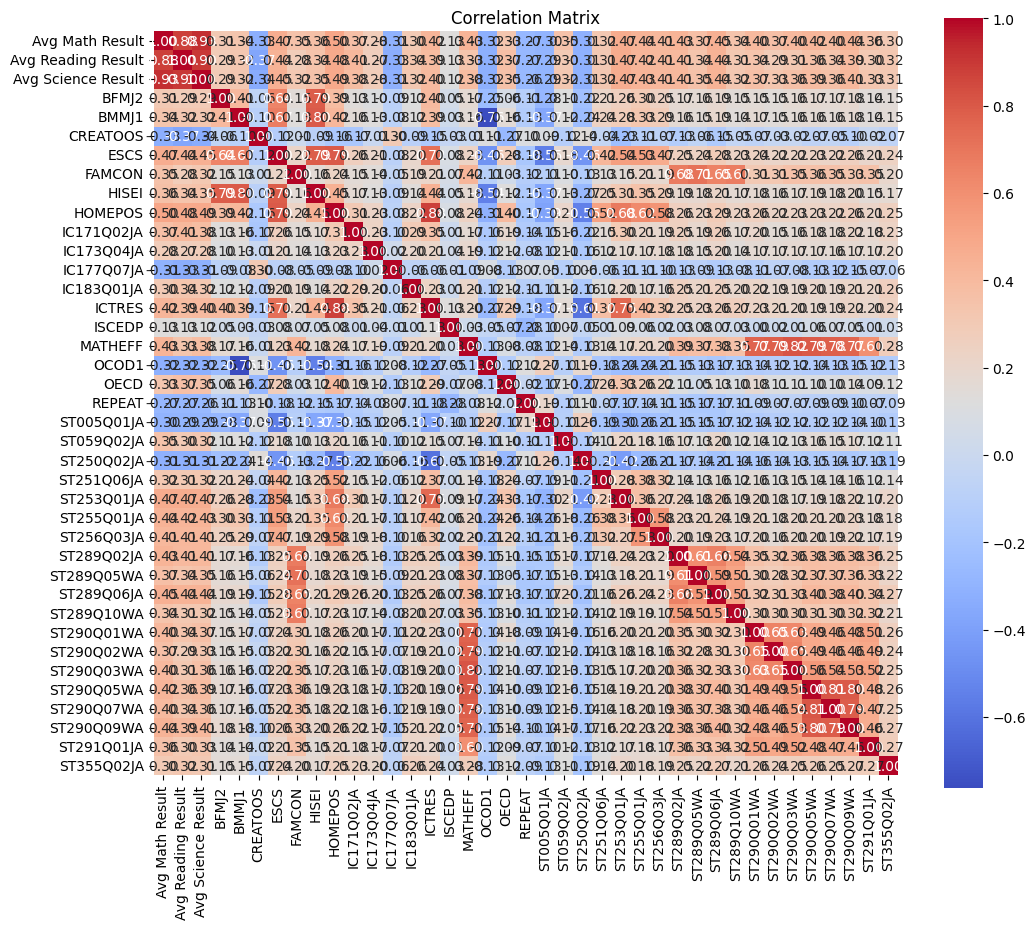

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

From the previous graph, we realized that 'Avg Science Result' had a high correlation with 'Avg Reading Result'. Also, the variable 'ST290Q05WA' is also very high correlated with 'ST290Q09WA' and 'ST290Q07WA'. These high correlations may affect the interpretability of the model by introducing redundancy among features. To address this, we decided to merge these correlated variables into a single composite variable.

In [20]:
filtered_cols_dataset = filtered_cols_dataset.drop(
    ["Avg Science Result", "ST290Q09WA", "ST290Q07WA"], axis=1
)
filtered_cols_dataset

,Avg Math Result,Avg Reading Result,BFMJ2,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,HOMEPOS,...,ST289Q02JA,ST289Q05WA,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST291Q01JA,ST355Q02JA
0,223.0351,249.8026,16.50,73.91,Below Average,NaN,1.1112,NaN,73.91,1.5995,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN
1,308.4938,288.8999,NaN,24.16,Below Average,NaN,-3.0507,NaN,24.16,-3.8115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,313.7353,311.7785,NaN,NaN,Below Average,NaN,-0.1867,NaN,NaN,0.2314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,298.7323,300.7753,14.82,NaN,Below Average,1.4468,-3.2198,0.4222,14.82,-2.5956,...,NaN,4.0,NaN,4.0,NaN,2.0,NaN,NaN,NaN,2.0
4,475.7512,486.6689,30.11,17.00,Below Average,1.8557,-1.0548,1.1266,30.11,-0.5632,...,5.0,4.0,NaN,4.0,1.0,NaN,NaN,2.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613739,327.0151,312.5706,28.95,17.00,Below Average,NaN,-2.7487,NaN,28.95,-0.9146,...,NaN,5.0,NaN,NaN,NaN,NaN,4.0,4.0,4.0,NaN
613740,286.4383,271.9545,30.11,73.91,Below Average,NaN,-0.2024,NaN,73.91,-2.1015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613741,411.8666,330.4373,25.71,17.00,Below Average,0.6097,-2.0506,NaN,25.71,-1.5194,...,4.0,4.0,NaN,NaN,NaN,3.0,3.0,4.0,3.0,NaN
613742,338.1192,353.0499,75.43,73.91,Below Average,NaN,-0.1290,NaN,75.43,-0.3975,...,NaN,NaN,NaN,NaN,3.0,3.0,NaN,3.0,4.0,NaN


In [22]:
filtered_cols_dataset.to_csv(
    "../../../databases/q3_database.csv",
    index=False,
)